<figure><right>
<img   src="../../figuras/logos/Logo_TalentQ_Azul.png" align=right  width="150px"/>
</right></figure>

# El arte de medir II




$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\mathcal H}} $
$ \newcommand{\boldn}{{\bf n}} $
$ \newcommand{\tr}{{\rm tr}}$



In [1]:
%run ../../macro_tQ.py
import sys
sys.path.append('../../')
import macro_tQ as tQ

import numpy as np
import scipy.linalg as la
from IPython.display import display,Markdown,Latex
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex

## Medidas de estados multicúbit

Un aparato de medida estándar  hace colapsar el estado a un elemento $\ket{x}$ de la *base computacional*, que identificamos mediante una cadena de bits $a_{n-1}...a_0$ con $a_i=0,1$,  donde $x= 2^{n-1}i_{n-1}+...+2^0 a_0$.

<br>
<figure><center>
<img src="images/Multimeter_zbasis.png" align=center width='400px'/>
<center></center>
</center></figure>

Este medidor está asociado al operador hermítico $\sigma_z^{\otimes n} = Z\otimes \ldots \otimes Z$

### Circuitos con múltiples cúbits y medidas en Qiskit

Un estado general en un circuito de $n$ cúbits se expresará en la base computacional

$$
\ket{\psi} = \sum_{i_{n-1},...,i_0= 0,1} c_{i_{n-1}...i_0} \ket{i_{n-1}...i_0} = \sum_a c_a \ket{a}
$$

Las medida es esencialmente un mapa entre n-cúbits cuánticos y n-bits clásicos.

$$
\ket{i_{n-1} i_{n-2}\, ... \, i_0} ~~\longrightarrow ~~ i_{n-1}i_{n-2}...i_0\in \{0,1\}^n
$$

La manera de tener acceso al valor absoluto de las amplitudes es midiendo repetidas veces para reconstruir la función de probabilidad

$$
|c_{i_{n-1} i_{n-2}...i_0}|^2 =p(i_{n-1} i_{n-2}...i_0)= \frac{n_{i_{n-1} i_{n-2}...i_0}}{N}
$$

donde $N$ es el número total de medidas.

<IPython.core.display.Latex object>

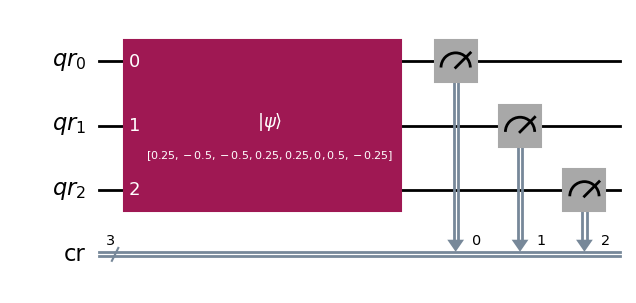

Cuentas= {'110': 24974, '001': 24831, '100': 6278, '011': 6274, '111': 6285, '000': 6289, '010': 25069}


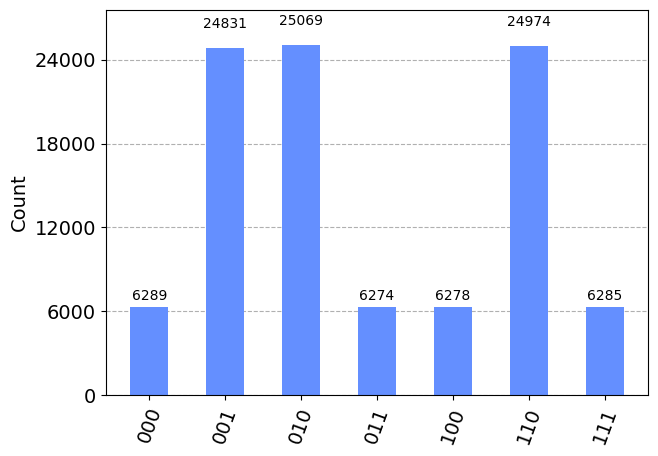

Probabilidades= {'110': 0.24974, '001': 0.24831, '100': 0.06278, '011': 0.06274, '111': 0.06285, '000': 0.06289, '010': 0.25069}


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy.linalg as la
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator 

'definimos un estado de entrada en H^3$'
psi =[1.,-2, -2,1,1,0,2,-1]
psi/=la.norm(psi)
display(Statevector(psi).draw('Latex'))

qr = QuantumRegister(3,name='qr')
cr = ClassicalRegister(3,name='cr')
qc_psi_Qs = QuantumCircuit(qr,cr)
qc_psi_Qs.initialize(psi,qr)
qc_psi_Qs.measure(qr[:],cr[:])
display(qc_psi_Qs.draw(output='mpl'))

'ejecutamos el circuito y graficamos la estadística de cuentas'
nshots = 100000

job=AerSimulator().run(qc_psi_Qs,shots=nshots) 
result=job.result()
counts = result.get_counts()        
print('Cuentas=',counts)        #diccionario de cuentas
display(plot_histogram(counts)) # Mostramos un histograma de resultados

'transformamos las cuentas en un diccionario de  probabilidades '    
probs_psi=counts.copy()         # vamos a modificar el diccionario "cuentas" con las probabilidades 
for bitstring,counts in probs_psi.items():
    probs_psi[bitstring]= counts/nshots

print('Probabilidades=', probs_psi)

## Medidas en bases generales

Al igual que en el capítulo anterior, desearíamos poder medir el estado en una base ortonormal arbitraria $\{\ket{ x}'\}$, $x=0,...,2^n-1$. 

Esto quiere decir que buscamos un circuito que, a la llegada de un vector  concreto de la base $\ket{x}'=\ket{a_{n-1}...a_0}'$, devuelva exactamente *la  colección* de bits:  $~a_{n-1}...a_0$ donde $a_i = 0,1$

$$
M : \ket{a_{n-1}...a_0}' ~~~~~~\Longrightarrow ~~~~~~ a_{n-1}...a_0
$$

Vamos a suponer que conocemos el operador unitario, $U$, que lleva la  base computacional a la base deseada 

$$\ket{a_{n-1}...a_0}'= U\ket{a_{n-1}...a_0}~~~~~~\Longleftrightarrow ~~~~~~   U^\dagger\ket{a_{n-1}...a_0}' = \ket{ a_{n-1}...a_0}  \, .$$

Entonces es evidente que sólo tenemos que añadir el operador $U^\dagger$ antes de usar el medidor estándar 
<br>
<br>


<figure>
<img src="images/Multimeter_basis.png" align=center width='450px'/>
<center></center>
</figure>

<br>

### Medidas  de Pauli

En caso más frecuente consiste en medir diferentes cúbits en diferentes bases de Pauli, $X$, $Y$ ó $Z$.
En este caso, $U$ es un producto de *rotaciones locales* en cada cúbit, $\ket{a_i}_x = H\ket{a_i}_z$ ó $\ket{a_i}_y = SH\ket{a_i}$.
Por ejemplo el siguiente circuito mide en la base $Z_0X_1Y_2$

<br>
<br>

<figure><center>
<img src="images/XYZ_multimeter.png" align=center width='250px'/>
<center></center>
</center></figure>

<br>

definamos una función que añade aparatos de medida en bases $X$, $Y$ ó $Z$ a partir de una *cadena* como 'xxy' etc. 

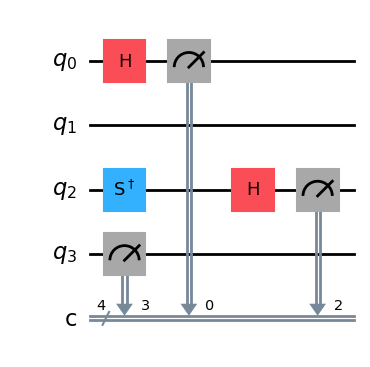

In [3]:
def add_multimeasure_XYZ(qc,paulistring):

    assert(qc.num_qubits==len(paulistring)) #check whether width of circuit coincides with length of Pauli string

    for i,basis in enumerate(reversed(paulistring)):
        if  basis == 'X':
            qc.h(i)    
            qc.measure(i, i)
        elif basis == 'Z':
            qc.measure(i, i)
            pass    
        elif basis == 'Y':
            qc.sdg(i)
            qc.h(i)
            qc.measure(i, i)

    return qc 

'Veamos un ejemplo'
from qiskit import QuantumCircuit
qc = QuantumCircuit(4,4)
add_multimeasure_XYZ(qc,'ZYIX')  # probar a cambiar el aparato de medida
qc.draw('mpl')

### Medida de Bell

El circuito 

<figure><center>
<img src="images/Bell_basis.png" align=center width='200px'/>
<center></center>
</center></figure>

<br>

 genera la <i>base de Bell</i> $\ket{B_{xy}} = \ket{xy}_B $ a partir de la <i>base computacional</i> $\{\ket{xy}\}$ 

$$
\begin{array}{rcl}
\ket{00}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} + \ket{11} \big) \\
\ket{01}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} + \ket{10} \big) \\
\ket{10}_B &=& \frac{1}{\sqrt{2}} \big( \ket{00} - \ket{11} \big) \\
\ket{11}_B &=& \frac{1}{\sqrt{2}} \big( \ket{01} - \ket{10} \big) \\
\end{array}
$$

El circuito que efectúa una medida en la base de Bell será, por tanto

$$
\ket{xy}_B \to xy
$$
utiliza el *desentrelazador* 

$$U^\dagger = ( \hbox{CNOT}\cdot H)^\dagger = H\cdot \hbox{CNOT}$$ 

antes del medidor 

<br>


<figure><center>
<img src="images/Bell_meter.png" align=center width='400px'/>
<center></center>
</center></figure>


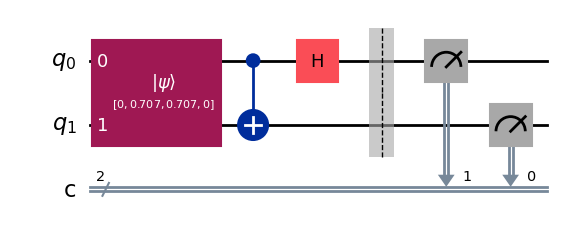

NameError: name 'execute' is not defined

In [7]:
def add_Bell_measurement(qc,qubits=[0,1]):
    qc.cx(qubits[0],qubits[1])
    qc.h(0)
    qc.barrier()
    qc.measure([0,1],[1,0])
    
'ahora verificamos'
from qiskit import QuantumCircuit

'creamos el circuito'
qc = QuantumCircuit(2,2)

'definimos la base de Bell'
B00 = np.array([1,0,0,1]/np.sqrt(2))
B01 = np.array([1,0,0,-1]/np.sqrt(2))
B10 = np.array([0,1,1,0]/np.sqrt(2))
B11 = np.array([0,1,-1,0]/np.sqrt(2))

'inicializamos el estado de entrada en cualquiera de los estados anteriores'
qc.initialize(B10,[0,1])

'añadimos el medidor en la base de Bell'
add_Bell_measurement(qc,[0,1])
display(qc.draw('mpl'))

execute(qc,backend=M_simulator).result().get_counts()

## Valores esperados de observables multi-cúbit

El *problema* esencial para medir un valor esperado $\bra{\psi} A \ket{\psi}$ es que, en general,  $A$ **no es un operador unitario**. Por tanto no se puede incluir como parte de un circuito

Si pudiésemos expresar  como una combinación de operadores unitarios, $A = \sum_i c_i U_i$, entonces sí podríamos calcular cada valor esperado $\langle U_i\rangle$ mediante un circuito y, finalmente, componer el resultado $\langle A\rangle = \sum_i c_i \langle U_i\rangle$

Una base  la constituyen la *base de cadenas de Pauli*,  $U = \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}$ que son, a la vez, hermíticas y unitarias

$$
A = \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \, \sigma_{i_1}\otimes \ldots \otimes \sigma_{i_n}
$$

donde $\sigma_i = (I,X,Y,Z)$. Por ejemplo, con $n=3$ 

$$
\sigma_2\otimes \sigma_0 \otimes \sigma_3 =  Y\otimes I\otimes Z 
$$

los coeficientes se pueden obtener calculando las trazas

$$
a_{i_1\ldots i_n} =\frac{1}{2^n} \tr (A \,  \sigma_{i_1}\otimes \ldots  \otimes\sigma_{i_n})
$$


Por tanto sólo tenemos que averiguar los valores esperados de cadenas de Pauli

$$
\langle A \rangle_{\psi} =  \sum_{i_1,...,i_n=0}^3 a_{i_1\ldots i_n} \langle \sigma_{i_1}\otimes \ldots   \otimes\sigma_{i_n}\rangle
$$

In [95]:
' Matrices de Pauli'
s0 = np.array([[1,0],[0,1]]) # matriz identidad
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

Pauli_basis = [s0,s1,s2,s3]

' Cadena de Pauli YIZ = s2s0s3' 
Pauli_string_203 = np.kron(s2,np.kron(s0,s3))
display(array_to_latex(Pauli_string_203,prefix='YIZ ='))

'Matriz arbitraria'
A = np.random.rand(8,8) + 1j* np.random.rand(8,8)

'Proyección a_203 de A sobre YIZ'
a_203 = np.trace(np.dot(A,Pauli_string_203))/2**3

print('a_203 = ', a_203)

<IPython.core.display.Latex object>

a_203 =  (-0.022249437380891343-0.025989132108195978j)


### Valores esperados de cadenas de Pauli

Veamos cómo calcular el valor esperado siguiente

$$
\langle Z\otimes Z\otimes Z\rangle_\Psi  = \bra{\Psi}   Z\otimes Z\otimes Z \ket{\Psi}
$$

Dado que $Z\ket{i} = (-1)^i\ket{i}$ donde $i=0,1$, insertando la identidad, el valor esperado  de este operador es

$$
\begin{array}{rcl}
\langle  Z\otimes Z\otimes Z\rangle_\Psi &=&
\bra{\Psi} Z\otimes Z\otimes Z \ket{\Psi} \\ 
&=& \sum_{i_2,i_1,i_0=0,1}\bra{\Psi} Z\otimes Z\otimes Z \ket{i_2 i_1 i_0}\braket{i_2 i_1 i_0}{\Psi}  \rule{0mm}{10mm}  \\ \rule{0mm}{10mm}
&=& \sum_{i_2,i_1,i_0=0,1}(-1)^{i_2 + i_1 + i_0}\big|\bra{i_2 i_1 i_0}\Psi\rangle\big|^2 \\ \rule{0mm}{10mm}
&=& \sum_{i_2,i_1,i_0=0,1} (-1)^{i_2 + i_1 + i_0} p(i_2,i_1,i_0) \nonumber\\ 
\end{array}
$$

Naturalmente, $\langle ZZZ\rangle $ es el valor medio  de la distribución de probabilidad  $\{\lambda(x),p(x)\},$ con $x=(i_2 i_1 i_0)$ 

$$
 \langle ZZZ\rangle = \bar \lambda = \sum_x \lambda(x) p(x) = \sum_{x}(-1)^{i_{2}+i_1+i_0}\frac{n(x)}{\sum_x n(x)} 
$$

También podemos obtener la varianza de esta distribución

$$
\sigma^2 = \sum_{x}\left((-1)^{i_{2}+i_1+i_0}-\bar\lambda \right)^2 p(x)
$$

In [96]:
'aprovechamos el diccionatio "probs_psi" creado al principio de este capítulo'

mean = 0
for bitstring,probs  in probs_psi.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * probs 

print('<ZZZ>_shots =', np.round(mean,5) )

'verificamos con la expresión analítica'
Z = np.array([[1,0],[0,-1]])
ZZZ = np.kron(s3,np.kron(s3,s3))
print('<ZZZ>_analitico =', tQ.braket(psi,np.dot(ZZZ,psi)) )

variance=0
for bitstring,probs  in probs_psi.items():
    variance += ((-1)**(sum([int(bit) for bit in bitstring]))-mean)**2 * probs
    
print('sigma = ', np.sqrt(variance) )

<ZZZ>_shots = -0.2496
<ZZZ>_analitico = -0.25
sigma =  0.9683490279852612


Ahora es muy evidente cómo medir el valor esperado de otras *cadenas de Pauli* en el mismo estado. Por ejemplo

$$
\langle Z\otimes X\otimes Y\rangle_\Psi  = \bra{\Psi}   Z\otimes X\otimes Y \ket{\Psi}
$$





In [98]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr,cr)


' ahora generamos el circuito que mide en la base ZXY'
qc.initialize(psi, qr)
add_multimeasure_XYZ(qc,'ZXY')
qc.draw(output='mpl')

counts = AerSimulator().run(qc,shots=nshots).result().get_counts()
print(counts)

mean = 0
for bitstring,count  in counts.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * count/nshots 

print('<ZXY> =', np.round(mean,5) )

'verificamos con la expresión analítica'
ZXY = np.kron(s3,np.kron(s2,s1))
print('<ZXY>_analitico =', tQ.braket(psi,np.dot(ZXY,psi)) )


{'110': 3147, '100': 15278, '001': 3204, '111': 3072, '011': 28284, '000': 3196, '010': 28183, '101': 15636}
<ZXY> = 0.00526
<ZXY>_analitico = 0j


<div class="alert alert-block alert-success">
 <b>Ejercicio</b>  
    
Considera el hamiltoniano $H=\lambda (X X+Y Y+Z Z)$ siendo $\lambda =1.47\cdot 10^{-6}eV$. 
 Calcular el valor esperado de la energía $E = \langle H\rangle_\Psi$  en los cuatro estados de Bell
$\ket{\Psi} = \ket{ij}_B$. 
</div>


### Medida de Hadamard

Al final, el valor esperado de un operador es un simple número que se obtiene a partir de una distribución aleatoria de valores. 
¿No podríamos diseñar una variable aleatoria cuyo valor medio coincida con ese resultado? 
La medida de Hadamard hace precisamente esto aprovechando el entrelazamiento. 

Consideremos el siguiente circuito


<figure><center>
<img src="images/Hadamard_measure.png" align=center width='280px'/>
<center></center>
</center></figure>


El aparato de medida sólo registra valores $\{0,1\}$ como resultado de las medidas proyectivas sobre los ejes $X$  ó $Y$. 
El circuito nos da dos posibilidades, medir $\sigma_x$ o hacerlo con $\sigma_y$. Supongamos que medimos $\sigma_x$. El promedio 

$$
p_{0}-p_{1} = \frac{n_{0}}{N} - \frac{n_{1}}{N} = \langle X\rangle_{ancilla}
$$

es el valor esperado de $X$ en la ancilla. 
Análogamente,  si usamos el observable $\sigma_x$ la misma cantidad $(n_0-n_1)/N$, será $\langle Y\rangle_{ancilla}$, el valor esperado de $Y$ en la ancilla. 

La magia del entrelazamiento es que estas dos cantidades poseen información que nos permite conocer el valor esperado de $U$ en el estado $\ket{\psi}$ **¡sin medirlo!**.


<div class="alert alert-block alert-info",text-align:center>
<p style="text-align: left ;color: navy;">  
<b>Teorema:</b>
<br>
$$
\langle X\rangle_{ancilla} = {\rm Re} \langle U\rangle_{\psi} ~~~,~~~ \langle Y\rangle_{ancilla} = {\rm Im} \langle U\rangle_{\psi}\, 
$$
</div>

<details>
<summary><p style="text-align: left ;color: navy"> >> Demostración </p></summary>
Un cálculo explícito nos da el estado que llega al aparato de medida
<br>

$$
\ket{0}\ket{\psi} ~\to ~ \ket{\Psi} = \frac{1}{2} \left[\rule{0mm}{3mm} |0\rangle \otimes  |\psi\rangle +  |1\rangle \otimes  U |\psi\rangle \right] \label{hadam}
$$

Entonces el valor esperado de $X$, medido en la ancilla será

$$
\bra{\Psi}(X\otimes I)\ket{\Psi} = \frac{1}{2}\big(\bra{\psi}U^\dagger\ket{\psi} + \bra{\psi}U\ket{\psi}\big)
=\hbox{Re}\, \bra{\psi}U\ket{\psi}
$$

Donde hemos usador que $X\ket{0} = \ket{1}$ y $X\ket{1} = \ket{0}$.

Análogamente, si lo que se ha medido es $\sigma_y$, entonces se trata del valor esperado

$$
\bra{\Psi}(Y\otimes I)\ket{\Psi} = \frac{1}{2}\big( -i \bra{\psi}U^\dagger\ket{\psi} + i \bra{\psi}U\ket{\psi}\big)
 = \hbox{Im}\, \bra{\psi}U\ket{\psi}
 $$

Donde hemos usador que $Y\ket{0} = i\ket{1}$ y $Y\ket{1} = -i\ket{0}$.
</details>



#### ¡A programar!    
Vamos a obtener el valor esperado de $\langle Z\otimes Z\otimes Z\rangle_\Psi$ en el estado 

$$
|\psi> = \frac{i}{4}|000>+\frac{1}{\sqrt{8}}|001>+\frac{1+i}{4}|010>+\frac{1+2i}{\sqrt{8}}|101>+\frac{1}{4}|110>
$$

usando el método de Hadamard. Generamos el circuito de medida de Hadamard

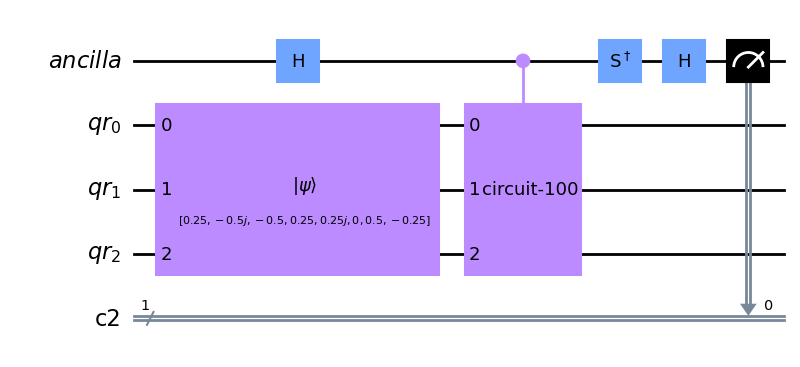

In [22]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

qr = QuantumRegister(3, name = 'qr')
qra = QuantumRegister(1, name = 'ancilla')
cr = ClassicalRegister(1)

'creamos el operador como una puerta "gate" que admite el método "control'
qc0 = QuantumCircuit(qr)
qc0.z(qr)
CZZZ_gate = qc0.to_gate().control(1,ctrl_state= 1) 

'creamos el circuito con el operador controlado'
qc_Had = QuantumCircuit(qra,qr,cr)
qc_Had.initialize(psi,qr)
qc_Had.h(qra)  
qc_Had.append(CZZZ_gate,qra[:] + qr[:])
qc_Had.sdg(qra)
qc_Had.h(qra)
qc_Had.measure(qra,cr)

qc_Had.draw('mpl')

Ejecutamos y obtenemos el valor esperado

{'0': 499847, '1': 500153}


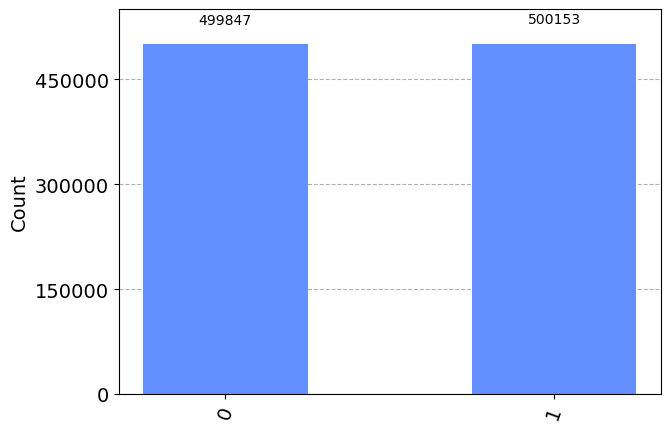

In [23]:
M_backend = Aer.get_backend('qasm_simulator')
shots=1000000

cuentas_Had= execute(qc_Had,M_backend,shots=shots).result().get_counts()
print(cuentas_Had)

from qiskit.tools.visualization import plot_histogram
plot_histogram(cuentas_Had)

<div class="alert alert-block alert-success">
<b>Ejercicio:</b>  
demuestra siguiendo los mismos pasos que midiendo en la ancilla del siguiente circuito los valores medios $\langle X\rangle_{ancilla}$ y 
$\langle Y\rangle_{ancilla}$     
<br>
<br>
    
<figure>
<img src="images/Hadamard_measured.png" align=center width='300px'/>
<center></center>
</figure>

obtenemos información acerca del valor esperados de $V^\dagger U$ en el estado $\ket{\psi}$
    
$$
\langle X\rangle_{ancilla} = \hbox{Re}\bra{\psi}V^\dagger U\ket{\psi} ~~~~,~~~~
\langle Y\rangle_{ancilla} = \hbox{Im}\bra{\psi}V^\dagger U\ket{\psi} ~~~~,~~~~
$$
</div>

#### Proyección de Hadamard

Consideremos el siguiente circuito sobre $\Hil\otimes \Hil$


<br>
<figure>
<img src="images/HadamardProjection.png" align=center width='300px'/>
<center></center>
</figure>
<br>

Escribamos el estado justo antes de llegar al aparato de medida

$$
\ket{0}\ket{\psi} \to \ket{\Psi} =  \ket{0}\otimes \frac{1}{2}(1+U)\ket{\psi} ~+~ \ket{0}\otimes \frac{1}{2}(1-U)\ket{\psi}
$$

Supongamos que el operador $U$ es un operador sobre 1 cúbit <u>*a la vez hermítico y unitario*</u>. Por ser unitario sus autovalores tienen que ser fases puras $\lambda = e^{i\varphi}$. Por ser hermítico, deben ser reales. 

Ello deja a $\lambda = \pm 1$ como los únicos autovalores posibles. 
Los operadores $X,Y,Z$ y $H$ son ejemplos de ello. 

Denominemos $\ket{a}_U = \{\ket{0}_U,\ket{1}_U\}$  los autovectores de $U$ con autovalores $(-1)^a = \pm 1$, es decir $U\ket{0}_U = \ket{0}_U$ y $U\ket{1}_U = -\ket{1}_U$. 

En este caso, los factores $\frac{1}{2}(1\pm U)$  son *proyectores ortogonales* sobre los autoestados de $U$. Efectivamente, cualquier estado se puede escribir en esta base $\ket{\psi} = \alpha\ket{0}_U + \beta\ket{1}_U$. Entonces

$$
\frac{1}{2}(1 + U) \ket{\psi} = \alpha \ket{0}_U~~~~~~~;~~~~~~~ \frac{1}{2}(1 - U) \ket{\psi} = \beta\ket{1}_U
$$

La imagen bajo este circuito de un estado de entrada $\ket{0}\ket{\psi}$  será, entonces, un estado entrelazado
<br>

$$
\ket{0}\ket{\psi} = \ket{0}\otimes (\alpha\ket{0}_U + \beta\ket{1}_U) ~~\longrightarrow ~~  \alpha\ket{0}\ket{0}_U +  \beta\ket{1}\ket{1}_U\, .
$$

Al igual que con los estados de Bell, cada resultado de  medida en la ancilla está correlacionado con un autoestado del operador $U$ en el segundo registro. 
